In [ ]:
!nvidia-smi

: 

In [2]:
import argparse
import torch
import torch.nn as nn
from torchvision import transforms as T
from src.dataset.vanilla_lpcvc import LPCVCDataset
import torchvision

from src.model.model import UNET

from tqdm import tqdm
import random
import numpy as np
import cv2
import PIL

import matplotlib.pyplot as plt
import albumentations as A

from sample_solution.evaluation.accuracy import AccuracyTracker
from matplotlib.colors import ListedColormap
import segmentation_models_pytorch as smp


IMG_WIDTH = 256
IMG_HEIGHT = 256

mean = [0.4607, 0.4558, 0.4192]
std = [0.1855, 0.1707, 0.1769]

colors = ['green', 'red', 'blue', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'pink', 'lime', 'brown', 'gray', 'olive', 'teal', 'navy']
cmap = ListedColormap(colors[:14])


ModuleNotFoundError: No module named 'cv2'

In [3]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=14, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]).to('cuda:1')

In [5]:
t_train = T.Compose([T.ToPILImage(), T.Resize(128,PIL.Image.NEAREST)])


# aug = A.Compose([A.Resize(128, 128, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
#                      A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.1),(0,0.1)),
#                      A.GaussNoise()])

aug = A.Compose([
    A.RandomCrop(width=IMG_WIDTH, height=IMG_HEIGHT, p=1.0),
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=1.0),
    A.Rotate(limit=[60, 240], p=1.0, interpolation=cv2.INTER_NEAREST),
    A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.2], contrast_limit=0.2, p=1.0),
    A.OneOf([
        A.CLAHE (clip_limit=2.0, tile_grid_size=(2, 2), p=0.5),
        A.GridDistortion(p=0.2),
        A.OpticalDistortion(distort_limit=0.4, shift_limit=0.3, interpolation=cv2.INTER_NEAREST, p=0.4),
    ], p=1.0),
], p=1.0)


train_dataset = LPCVCDataset(datapath='/home/infres/nvernier-22/project/LPCVC-2023/dataset/',transform=aug, n_class=14, train=True)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)




/home/infres/nvernier-22/anaconda3/envs/lpcvc/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [93]:
running_mean = 0
for i in range(len(train_dataset)):
    img, _ = train_dataset[i]
    img = np.array(img[0,:,:])
    running_mean += np.mean(img)
print(running_mean/len(train_dataset))
    

0.17699541474430733


(14, 512, 512)
[ 0  5 10 12]


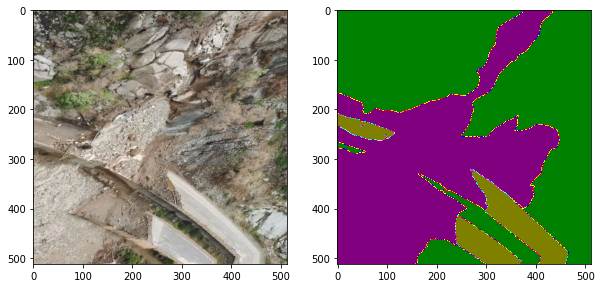

In [167]:
img, label = train_dataset[8]

print(label.shape)

labels = label.reshape(1, 14, IMG_WIDTH, IMG_HEIGHT)
labels = torch.tensor(labels).to('cuda:1')
labels = labels.reshape((1, 14,  IMG_WIDTH, IMG_HEIGHT))

labels = labels.cpu().data.max(1)[1].numpy()
labels.astype(np.uint8)
labels = np.squeeze(labels, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Affichage de la première image
axes[0].imshow(np.transpose(img, (1, 2, 0)))

# Affichage de la deuxième image
axes[1].imshow(labels, vmin=0, vmax=13, cmap=cmap)

print(np.unique(labels))


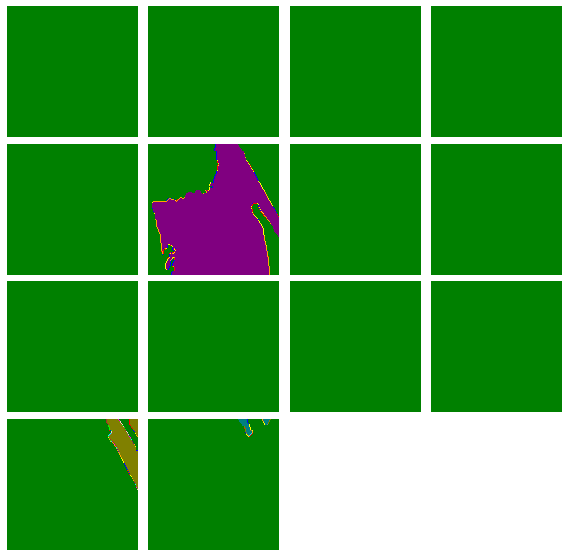

In [65]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

# Parcours des images et tracé dans chaque sous-graphique
for i, ax in enumerate(axes.flatten()):
    if i < len(label):
        img = label[i]*(i)
        ax.imshow(img, vmin=0, vmax=13, cmap=cmap)
        ax.axis('off')
    else:
        ax.axis('off')

# Réglage des marges entre les sous-graphiques
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Affichage du graphique
plt.show()

In [ ]:
LEARNING_RATE = 1e-4


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
def train(model, criterion, optimizer, scaler, train_loader):
    model.train()
    running_loss=0
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        
        data = data.to(device='cuda:1')
        targets = targets.to(device='cuda:1')        
            
        with torch.cuda.amp.autocast():
            outputs=model(data)
            if(batch_idx == 0):
                output_n = outputs.detach().cpu().numpy()
                target_n = targets.detach().cpu().numpy()
                data_n = data[0].detach().cpu().numpy()

                # output_n = np.argmax(output_n[0], axis=0)
                # output_n[output_n != 0] = -1
                # output_n[output_n == 0] = 1
            
                output_n = np.argmax(output_n[0], axis=0)
                target_n = np.argmax(target_n[0], axis=0)

                plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/input'+str(0)+'.png', data_n[0])
                plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/predict'+str(0)+'.png', output_n)
                plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/target'+str(0)+'.png', target_n)
            loss = criterion(outputs, targets)
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())
            
        running_loss += loss.item()

    train_loss=running_loss/len(train_loader)
        
    print('Train Loss: %.3f'%(train_loss))
    return(train_loss)

In [ ]:

def draw(i):
    data, target = train_dataset[0]
    data = torch.tensor(data.reshape((1, 3, 128, 128))).to('cuda:1')
    target = torch.tensor(target.reshape((1, 14, 128, 128))).to('cuda:1')
                   
    output=model(data)

    _, predicted = output.max(1)

    print(predicted.shape)

    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()

    output = np.argmax(output[0], axis=0)
    plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/predict'+str(i)+'.png', output[ :, :])
    if(i==1):
        plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/target'+str(i)+'.png', target[0, 0, :, :])

In [ ]:
for epoch in range(1, 100):
    print('\nEpoch : %d'%epoch)
    train(model, criterion=criterion, optimizer=optimizer, scaler=scaler, train_loader=train_loader)
    draw(epoch)


In [ ]:
torch.save(model.state_dict(), 'src/model/vanilla-lpcvc_'+str(100)+'.pth')

In [4]:
model.load_state_dict(torch.load("/home/infres/nvernier-22/project/LPCVC-2023/vanilla-lpcvc_unet_340_32_dice_0.6639399152807897.pth"))

<All keys matched successfully>

In [6]:
transform = A.Compose([A.Resize(width=IMG_WIDTH, height=IMG_HEIGHT, interpolation=cv2.INTER_NEAREST)])
test_dataset = LPCVCDataset(datapath='/home/infres/nvernier-22/project/LPCVC-2023/dataset/',mean=mean, std=std, transform=transform, n_class=14, train=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


In [ ]:
!nvidia-smi

In [8]:
len(test_dataset)

100

In [12]:

loop = tqdm(test_loader)

model.eval()
accuracyTracker: AccuracyTracker = AccuracyTracker(n_classes=14)
accuracyTracker.reset()
tot_m_dice = 0
tot = 0
with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(loop):
        if(batch_idx > 10):
            break
        tot += 1
        data = data.to(device='cuda:1')
        targets = targets.to(device='cuda:1')     

        preds = model(data)

        preds = preds.cpu().data.max(1)[1].numpy()
        data = data.cpu().numpy()
        targets = targets.cpu().data.max(1)[1].numpy()
        preds.astype(np.uint8)
        targets.astype(np.uint8)

        if(batch_idx%2==0):
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            # Tracé de la première image
            axes[0].imshow(np.transpose(data[0]*0.13+0.5, (1, 2, 0)))
            axes[0].imshow(preds[0], cmap=cmap, vmin=0, vmax=13, alpha=0.3)
            axes[0].axis('off')

            # Tracé de la deuxième image
            axes[1].imshow(np.transpose(data[0]*0.13+0.5, (1, 2, 0)))
            axes[1].imshow(targets[0], cmap=cmap, vmin=0, vmax=13, alpha=0.3)
            axes[1].axis('off')

        accuracyTracker.update(targets, preds)
print(tot)
print(accuracyTracker.get_mean_dice())

NameError: name 'train_loader' is not defined